In [178]:
import pystac as ps
import pystac.utils as ps_utils
from pystac import Item, Collection, Catalog
from pystac.item_collection import ItemCollection
from pystac.extensions.eo import EOExtension
import stackstac
import dask
from dask import delayed
import rasterio as rio
from rasterio.plot import show

In [119]:
import json, os, sys, traceback

In [142]:
from dask.distributed import Client

client = Client(n_workers=4)
client

/Users/kendallsmith/opt/anaconda3/envs/mlhub/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59107 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59107/status,
Dashboard: http://127.0.0.1:59107/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59108,Workers: 4
Dashboard: http://127.0.0.1:59107/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:59122,Total threads: 2
Dashboard: http://127.0.0.1:59125/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:59111,


In [99]:
MLHUB_BLOB_ROOT = 'https://radiantmlhub.blob.core.windows.net/stac/landcovernet-v1'
MLHUB_SOURCE_ROOT = 'https://radiantmlhub.blob.core.windows.net/stac/landcovernet-v1/landcovernet_v1_source'
MLHUB_LABELS_ROOT = 'https://radiantmlhub.blob.core.windows.net/stac/landcovernet-v1/landcovernet_v1_labels'
CATALOG_NAME = 'landcovernet-v1'

In [79]:
TMP_DIR = os.getcwd()

In [80]:
source_collection_path = '/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_source/collection.json'
labels_collection_path = '/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_labels/collection.json'

In [81]:
# stac_io = ps.StacIO.default()
# stac_io.read_stac_object(...)

In [129]:
lcn_labels_collection = Collection.from_file(labels_collection_path)

In [130]:
lcn_source_collection = Collection.from_file(source_collection_path)

In [126]:
def make_collection_links_relative(collection, absolute_root):
    try:
        if isinstance(collection, Collection):
            for collection_link in collection.get_child_links():
                collection_link.target = ps_utils.make_relative_href(
                    collection_link.get_target_str(),
                    start_href=absolute_root,
                    start_is_dir=True
                )
    except Exception:
        print("Exception making Collection child links relative to collection:")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)
        print("-"*60)

In [127]:
# %%time
def make_item_targets_relative(collection, absolute_root):
    try:
        if isinstance(collection, Collection):
            for item_link in collection.get_item_links():
                # First, get the Item's URL relative to the original catalog at the broken Azure URL
                relative_to_root = ps_utils.make_relative_href(
                    item_link.get_target_str(),
                    start_href=absolute_root,
                    start_is_dir=True
                )
                # print(relative_to_root)

                # Next, get the absolute local path and then the path relative to the collection
                absolute_path = ps_utils.make_absolute_href(
                    relative_to_root,
                    start_href=collection.get_root_link().href
                )
                # print(absolute_path)

                relative_to_collection = ps_utils.make_relative_href(
                    absolute_path,
                    start_href=collection.get_self_href()
                )
                item_link.target = relative_to_collection
            return collection
        return None
    except Exception:
        print("Exception making Item target links relative to collection:")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)
        print("-"*60)

In [128]:
def update_collection_links(collection, root):
    make_collection_links_relative(collection, root)
    make_item_targets_relative(collection, root)

In [131]:
update_collection_links(lcn_labels_collection, MLHUB_LABELS_ROOT)
update_collection_links(lcn_source_collection, MLHUB_SOURCE_ROOT)

In [132]:
lcn_source_collection.get_links()[0:10]

[<Link rel=root target=<Collection id=ref_landcovernet_v1_source>>,
 <Link rel=self target=/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_source/collection.json>,
 <Link rel=item target=./landcovernet_v1_source_28QDE_00_20180103/landcovernet_v1_source_28QDE_00_20180103.json>,
 <Link rel=item target=./landcovernet_v1_source_28QDE_00_20180108/landcovernet_v1_source_28QDE_00_20180108.json>,
 <Link rel=item target=./landcovernet_v1_source_28QDE_00_20180113/landcovernet_v1_source_28QDE_00_20180113.json>,
 <Link rel=item target=./landcovernet_v1_source_28QDE_00_20180118/landcovernet_v1_source_28QDE_00_20180118.json>,
 <Link rel=item target=./landcovernet_v1_source_28QDE_00_20180123/landcovernet_v1_source_28QDE_00_20180123.json>,
 <Link rel=item target=./landcovernet_v1_source_28QDE_00_20180128/landcovernet_v1_source_28QDE_00_20180128.json>,
 <Link rel=item target=./landcovernet_v1_source_28QDE_00_20180202/landcovernet_v1_source_28QDE_00_20180202.json>,
 <Link rel

In [133]:
lcn_labels_collection.get_links()[0:10]

[<Link rel=root target=<Collection id=ref_landcovernet_v1_labels>>,
 <Link rel=self target=/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_labels/collection.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_00/landcovernet_v1_labels_28QDE_00.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_01/landcovernet_v1_labels_28QDE_01.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_02/landcovernet_v1_labels_28QDE_02.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_03/landcovernet_v1_labels_28QDE_03.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_04/landcovernet_v1_labels_28QDE_04.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_05/landcovernet_v1_labels_28QDE_05.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_06/landcovernet_v1_labels_28QDE_06.json>,
 <Link rel=item target=./landcovernet_v1_labels_28QDE_07/landcovernet_v1_labels_28QDE_07.json>]

In [134]:
lcn_source_collection.get_item('ref_landcovernet_v1_source_28QDE_00_20180103')

<Item id=ref_landcovernet_v1_source_28QDE_00_20180103>

In [136]:
lcn_labels_collection.get_item('ref_landcovernet_v1_labels_28QDE_00')

<Item id=ref_landcovernet_v1_labels_28QDE_00>

In [115]:
next(lcn_source_collection.get_all_items()).to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'ref_landcovernet_v1_source_28QDE_00_20180103',
 'properties': {'datetime': '2018-01-03T00:00:00Z',
  'eo:bands': [{'name': 'B01',
    'common_name': 'Coastal Aerosol',
    'description': 'Coastal Aerosol'},
   {'name': 'B02', 'common_name': 'Blue', 'description': 'Blue'},
   {'name': 'B03', 'common_name': 'Green', 'description': 'Green'},
   {'name': 'B04', 'common_name': 'Red', 'description': 'Red'},
   {'name': 'B05',
    'common_name': 'Vegetation Red Edge',
    'description': 'Vegetation Red Edge (704.1nm)'},
   {'name': 'B06',
    'common_name': 'Vegetation Red Edge',
    'description': 'Vegetation Red Edge (740.1nm)'},
   {'name': 'B07',
    'common_name': 'Vegetation Red Edge',
    'description': 'Vegetation Red Edge (782.8nm)'},
   {'name': 'B08', 'common_name': 'NIR', 'description': 'NIR'},
   {'name': 'B8A', 'common_name': 'Narrow NIR', 'description': 'Narrow NIR'},
   {'name': 'B09',
    'common_name': 'Water Vapour',
   

In [168]:
next(lcn_source_collection.get_all_items()).get_assets()['CLD'].href

'https://radiantearth.blob.core.windows.net/mlhub/landcovernet/data/v1.0/2018/28QDE/00/28QDE_00_20180103/28QDE_00_20180103_CLD_10m.tif'

In [170]:
i=0
while i<1000:
    item = next(lcn_source_collection.get_all_items())
    test_item_href = item.get_assets()['CLD'].href
    test_src = rio.open(test_item_href)
    cloud_cover = (test_src.read().sum() / (test_src.width * test_src.height)) * 100
    if cloud_cover > 0:
        print(f'Item {item.id} has {cloud_cover:.2f}% clouds')
    i+=1

In [159]:
test_item_href = item.get_assets()['CLD'].href

In [160]:
test_src = rio.open(test_item_href)

In [164]:
test_src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 256,
 'height': 256,
 'count': 1,
 'crs': CRS.from_epsg(32628),
 'transform': Affine(10.0, 0.0, 407760.0,
        0.0, -10.0, 1985740.0)}

In [161]:
test_src.width

256

In [162]:
test_src.height

256

In [165]:
source_epsg = test_src.crs.to_epsg()

In [157]:
(test_src.read().sum() / (test_src.width * test_src.height)) * 100

0.0

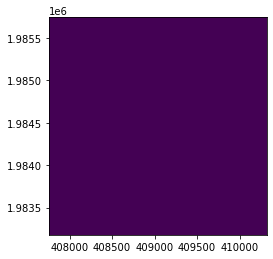

<AxesSubplot:>

In [163]:
show(test_src)

In [173]:
%%time
lcn_source_items = list(lcn_source_collection.get_all_items())

CPU times: user 2.31 s, sys: 3.53 s, total: 5.84 s
Wall time: 13.1 s


In [182]:
@delayed
def calculate_cloud_cover(item):
    test_item_href = item.get_assets()['CLD'].href
    test_src = rio.open(test_item_href)
    cloud_cover = (test_src.read().sum() / (test_src.width * test_src.height)) * 100
    eo_ext = EOExtension.ext(item)
    eo_ext.cloud_cover = cloud_cover
    return item

In [ ]:
scattered_items = client.scatter(lcn_source_items)
scattered_items

In [ ]:
cloud_futures = client.submit(calculate_cloud_cover, scattered_items)

In [181]:
cloud_results = []

for item in lcn_source_items:
    cc_item = delayed(calculate_cloud_cover)(item)
    cloud_results.append(cc_item)
    
cc_item.compute()

/Users/kendallsmith/opt/anaconda3/envs/mlhub/lib/python3.9/site-packages/distributed/worker.py:4370: UserWarning: Large object of size 0.94 GiB detected in task graph: 
  (<Item id=ref_landcovernet_v1_source_38PKT_29_20181227>,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x12f8d8c10> (for post_execute):



KeyboardInterrupt



In [ ]:
# results = []

# for x in data:
#     y = delayed(inc)(x)
#     results.append(y)
    
# total = delayed(sum)(results)
# print("Before computing:", total)  # Let's see what type of thing total is
# result = total.compute()
# print("After computing :", result)  # After it's computed

In [171]:
# %%time
# source_data = stackstac.stack(
#     items=ItemCollection(source_items),
#     assets=['CLD'],
#     dtype="float32",
#     resolution=10,
#     epsg=source_epsg,
# )

In [114]:
lcn_source_items = lcn_source_collection.get_all_items()
lcn_source_items

In [19]:
type(source_items)

map

In [25]:
with open(source_collection_path, 'r') as in_file:
    source_data = json.load(in_file)

In [26]:
source_data.keys()

dict_keys(['id', 'stac_version', 'description', 'links', 'extent', 'license', 'stac_extensions', 'providers', 'sci:doi', 'sci:citation', 'type'])

In [28]:
len(source_data['links'])

153767

In [29]:
source_data['links'][0]

{'href': 'https://radiantmlhub.blob.core.windows.net/stac/landcovernet-v1/landcovernet_v1_source/collection.json',
 'rel': 'self'}

In [38]:
for link in source_data['links']:
    link['href'] = link['href'].replace(MLHUB_STORAGE_ROOT, TMP_DIR)

In [39]:
source_data['links'][0]

{'href': '/Users/kendallsmith/scalable-model-training/landcovernet_v1_source/collection.json',
 'rel': 'self'}

In [103]:
lcn_source_collection.get_root_link().href

'/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_source/collection.json'

In [104]:
lcn_source_collection.get_self_href()

'/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_source/collection.json'

In [105]:
lcn_labels_collection.get_self_href()

'/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_labels/collection.json'

In [106]:
first_source_link = lcn_source_collection.get_item_links()[0]

In [107]:
relative_to_root = ps_utils.make_relative_href(
    first_source_link.get_target_str(),
    start_href=MLHUB_SOURCE_ROOT,
    start_is_dir=True
)

relative_to_root

'./landcovernet_v1_source_28QDE_00_20180103/landcovernet_v1_source_28QDE_00_20180103.json'

In [108]:
absolute_path = ps_utils.make_absolute_href(
    relative_to_root,
    start_href=lcn_source_collection.get_root_link().href
)

absolute_path

'/Users/kendallsmith/scalable-model-training/landcovernet-v1/landcovernet_v1_source/landcovernet_v1_source_28QDE_00_20180103/landcovernet_v1_source_28QDE_00_20180103.json'

In [109]:
relative_to_collection = ps_utils.make_relative_href(
    absolute_path,
    start_href=lcn_source_collection.get_self_href()
)

relative_to_collection

'./landcovernet_v1_source_28QDE_00_20180103/landcovernet_v1_source_28QDE_00_20180103.json'